In [ ]:
# export
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from fastcore.all import *
from transformers import AutoTokenizer

In [ ]:
# default_exp data_birds

In [ ]:
data_dir = Path('../data/tiny_data/birds')

# Data Birds
> 

## Items

In [ ]:
# exporti
def preprocess_text(s):
    "remove weird text ��, only keep english words, lowercase"
    s = s.replace("\ufffd\ufffd", " ")
    s = re.sub(r'[^\w\s]','',s)
    return s.lower()

In [ ]:
s = "This��small��bird��has��a��white��belly,��black"
test_eq(preprocess_text(s), 'this small bird has a white belly black')

In [ ]:
# exporti
def get_caps(caps_dir, img_name):
    "returns list of caps for this img"
    caps = (caps_dir/img_name).with_suffix('.txt').read().splitlines()
    caps = [preprocess_text(cap) for cap in caps]
    caps = [cap for cap in caps if len(cap.split())>1]
    return caps

In [ ]:
get_caps(data_dir/'caps', '001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg')

['light tan colored bird with a white head and an orange beak',
 'the bird has a very thick curved and beige beak',
 'this bird has a long neck that is grainy and a pastel orangeblue narrow beak that droops down at the tip',
 'this bird is light brown has a long hooked bill and looks dumb',
 'this large white bird has a large curved bill and a brown eye',
 'this bird is white with grey and has a long pointy beak',
 'this bird is white with grey and has a long pointy beak',
 'the crown of the bird is white with light brown tones throughout',
 'the crown of the bird has distinctive tones of white and brown throughout',
 'this bird has a long neck and an orange bill']

In [ ]:
# exporti
def get_items(data_dir, pct=1):
    " returns: List of (img_loc, bbox, caps) "
    # bbox: [x-left, y-top, width, height]
#     split_loc = data_dir/'train_test_split.txt'
#     splits = [o.split()[1] for o in split_loc.read().splitlines()]
    
    img_names_loc = data_dir/'images.txt'
    img_names = [o.split()[1] for o in img_names_loc.read().splitlines()]
    img_dir = data_dir/'imgs'
    img_locs = [img_dir/img_name for img_name in img_names]
    
    bbox_loc = data_dir/'bounding_boxes.txt'
    bboxes = [L(o.split()[1:]).map(float) for o in bbox_loc.read().splitlines()]
    
    caps_dir = data_dir/'caps'
    caps = [get_caps(caps_dir, img_name) for img_name in img_names]
    
    num = int(len(img_names)*pct)
#     return [(splits[i], img_locs[i], bboxes[i], caps[i]) for i in range(num)]
    return [(img_locs[i], bboxes[i], caps[i]) for i in range(num)], []

In [ ]:
train_items, valid_items = get_items(data_dir)
len(train_items), train_items[0]

(282,
 (Path('../data/tiny_data/birds/imgs/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'),
  (#4) [60.0,27.0,325.0,304.0],
  ['light tan colored bird with a white head and an orange beak',
   'the bird has a very thick curved and beige beak',
   'this bird has a long neck that is grainy and a pastel orangeblue narrow beak that droops down at the tip',
   'this bird is light brown has a long hooked bill and looks dumb',
   'this large white bird has a large curved bill and a brown eye',
   'this bird is white with grey and has a long pointy beak',
   'this bird is white with grey and has a long pointy beak',
   'the crown of the bird is white with light brown tones throughout',
   'the crown of the bird has distinctive tones of white and brown throughout',
   'this bird has a long neck and an orange bill']))

In [ ]:
# # exporti
# def split_items(items):
#     ''' items: List of (split, img_loc, bbox, caps) 
#         returns: train_items, valid_items(List of (img_loc, bbox, caps)) '''
#     train_items = []
#     valid_items = []
#     for item in items:
#         if item[0]=='1':
#             train_items.append((item[1], item[2], item[3]))
#         elif item[0]=='0':
#             valid_items.append((item[1], item[2], item[3]))
#         else:
#             raise Exception('Opps!!!')
#     return train_items, valid_items

In [ ]:
# train_items, valid_items = split_items(items)
# test_eq(len(train_items), 150)
# test_eq(len(valid_items), 132)
# train_items[0]

## Datasets

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [ ]:
tokenizer.encode('This is a cat', max_length=2, pad_to_max_length=True, add_special_tokens=False)

[48, 25]

In [ ]:
# export
class BertTokenizer():
    def __init__(self):
        self.tok = AutoTokenizer.from_pretrained('albert-base-v2')
#         self.bos_id = self.tok.cls_token_id
#         self.eos_id = self.tok.sep_token_id
        self.max_seq_len = 25
        self.pad_id = self.tok.pad_token_id
        self.vocab_sz = self.tok.vocab_size
    def encode(self, o):
        toks = self.tok.encode(o, max_length=self.max_seq_len, pad_to_max_length=True, add_special_tokens=False)
        tok_len = sum([1 if tok!=self.pad_id else 0 for tok in toks])
        return toks, tok_len
    def decode(self, o):
        return self.tok.decode(o, skip_special_tokens=True)

In [ ]:
tokenizer = BertTokenizer()
ori_str = 'the bird has a very thick curved and beige beak'
out, tok_len = tokenizer.encode(ori_str)
test_eq(out, [14, 2838, 63, 21, 253, 2318, 9279, 17, 44, 49, 834, 44, 1378, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
test_eq(tok_len, 13)
test_eq(len(out), tokenizer.max_seq_len)
test_eq(tokenizer.decode(out), ori_str)
tokenizer.pad_id, tokenizer.vocab_sz

(0, 30000)

In [ ]:
# exporti
def crop_by_bbox(img, bbox):
    width, height = img.size
    r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
    center_x = int((2 * bbox[0] + bbox[2]) / 2)
    center_y = int((2 * bbox[1] + bbox[3]) / 2)
    y1 = np.maximum(0, center_y - r)
    y2 = np.minimum(height, center_y + r)
    x1 = np.maximum(0, center_x - r)
    x2 = np.minimum(width, center_x + r)
    img = img.crop([x1, y1, x2, y2])
    return img

In [ ]:
# exporti
class BirdsDataset(Dataset):
    def __init__(self, items):
        self.items = items
        self.tokenizer = BertTokenizer()
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        return self.tfm(self.items[idx])
    def tfm(self, item):
        ''' item: (img_loc, bbox, caps), 
            returns: cap: (25,), cap_len: (), img: (256, 256, 3) '''
        img_loc, bbox, caps = item
        cap, cap_len = self.tokenizer.encode(random.choice(caps))
        img = np.array(crop_by_bbox(Image.open(img_loc), bbox).resize((256, 256)))
        if len(img.shape)==2:
            img = np.repeat(img[...,None], 3, axis=2)
        return torch.tensor(cap), torch.tensor(cap_len), torch.tensor(img)

tensor([  48, 2838,   63,   21,  175, 1425,   17,   40, 2987, 1071,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]) tensor(10)


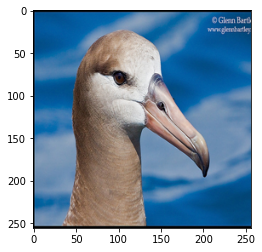

In [ ]:
dset = BirdsDataset(train_items)
cap, cap_len, img = dset[0]
test_eq(cap.shape, (dset.tokenizer.max_seq_len,))
test_eq(cap_len.shape, ())
test_eq(img.shape, (256, 256, 3))

print(cap, cap_len)
plt.imshow(img)

In [ ]:
# export
class Datasets():
    def __init__(self, data_dir, pct=1):
        train_items, valid_items = get_items(data_dir, pct=pct)
        self.train = BirdsDataset(train_items)
        self.valid = BirdsDataset(valid_items)

In [ ]:
dsets = Datasets(data_dir)
test_eq(len(dsets.train), 282)
test_eq(len(dsets.valid), 0)

## DataLoaders

In [ ]:
# export
class DataLoaders():
    def __init__(self, dsets, bs=64):
        self.dsets = dsets
        self.train = DataLoader(dsets.train, batch_size=bs, shuffle=True, num_workers=2, drop_last=True)
        self.valid = DataLoader(dsets.valid, batch_size=bs, shuffle=False, num_workers=2)

In [ ]:
dls = DataLoaders(dsets, bs=16)

In [ ]:
for cap, cap_len, img in dls.train:
    test_eq(cap.shape, (16, dls.train.dataset.tokenizer.max_seq_len))
    test_eq(cap_len.shape, (16,))
    test_eq(img.shape, (16, 256, 256, 3))
    break

## Export -

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_utils.ipynb.
Converted 02a_data_anime_heads.ipynb.
Converted 02b_data_birds.ipynb.
Converted 03a_model.ipynb.
Converted 04a_trainer_DAMSM.ipynb.
Converted 04b_trainer_GAN.ipynb.
Converted 05a_inference_anime_heads.ipynb.
Converted 05b_inference_birds.ipynb.
Converted index.ipynb.
